# **ML 200: Parallelized Data Science Workflow with Dask-cloudprovider EC2Cluster**

> # i.e., <font color='#8735fb'> RAPIDS + Dask @ 20 years of Airlines Dataset </font>

In this notebook we will be using dask_cudf to read and merge datasets on multiple GPUs. Dask_cudf dataframes are very similar to Dask dataframes with one key distinction - Dask dataframes are made of multiple partitions where each partition is a pandas dataframe.

For dask_cudf our partitions will live on the GPU and are cudf dataframes which gives us awesome performance gains and let's us use a high-level dataframe api to interact with a distributed dataset that is in GPU memory!


**1. Data Loading**

**2. ETL**
- Merge/Join
- Handling Missing Values
    
**3. Visualization**
- Cross-correlation Plot
- Bar Plot
    
**4. Feature Engineering**
- Create Indicator Variables
- Data Rescaling
    
**5. Modeling**
- Random Forest
- XGBoost

**6. Explore**    


In [7]:
import dask_cloudprovider
dask_cloudprovider.__version__

'0.5.0'

In [5]:
# !pip uninstall -y dask-cloudprovider

Found existing installation: dask-cloudprovider 0.5.0
Uninstalling dask-cloudprovider-0.5.0:
  Successfully uninstalled dask-cloudprovider-0.5.0


In [ ]:
# !pip install git+https://github.com/dask/dask-cloudprovider.git#egg=dask-cloudprovider[aws]

In [ ]:
# !conda install -y jupyterlab nodejs
# !conda install -y -c conda-forge dask-labextension
# !jupyter labextension install dask-labextension
# !jupyter serverextension enable dask_labextension
# conda install -y -c conda-forge dask-cloudprovider=0.5.1

In [77]:
from dask.distributed import Client, LocalCluster
from dask_cuda import LocalCUDACluster
import dask_cudf
import cudf

In [12]:
import configparser
import os
import contextlib

In [10]:
# Function to read AWS credentials to be passed to EC2Cluster
def get_aws_credentials():
    """Read in your AWS credentials file and convert to environment variables."""
    parser = configparser.RawConfigParser()
    
    parser.read(os.path.expanduser('~/.aws/config'))
    config = parser.items('default')
    
    parser.read(os.path.expanduser('~/.aws/credentials'))
    credentials = parser.items('default')
    
    all_credentials = {key.upper(): value for key, value in [*config, *credentials]}
    with contextlib.suppress(KeyError):
        all_credentials["AWS_REGION"] = all_credentials.pop("REGION")
        
    return all_credentials

In [13]:
env_vars = get_aws_credentials()
env_vars["EXTRA_CONDA_PACKAGES"] = "s3fs"  # The workers will need `s3fs` to read from S3.

In [14]:
# Create dask-cloudprovider EC2Cluster
from dask_cloudprovider.aws import EC2Cluster
from dask.distributed import wait

cluster = EC2Cluster(ami="ami-06d62f645899df7de",  # Example Deep Learning AMI (Ubuntu 18.04) # AWS AMI id can be region specific
                             docker_image="rapidsai/rapidsai:cuda11.0-runtime-ubuntu18.04",
#                              docker_image="084159221011.dkr.ecr.us-east-2.amazonaws.com/rapids-custom:latest",
                             instance_type="g4dn.xlarge",
#                              instance_type="p3.2xlarge",
#                              worker_module="dask_cuda.cli.dask_cuda_worker", # This is a bug with 0.5.0
                             worker_class="dask_cuda.CUDAWorker", 
                             n_workers=1,
                             bootstrap=False,
                             filesystem_size=120, env_vars=env_vars )

Creating scheduler instance
Created instance i-0a45e706c4df24073 as dask-3c5bcf7e-scheduler
Waiting for scheduler to run
Scheduler is running


/home/dgxuser/anaconda3/envs/daskcp/lib/python3.7/contextlib.py:119: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources. Hang tight! 
  next(self.gen)


Creating worker instance
Created instance i-041e762277d6184d6 as dask-3c5bcf7e-worker-5924c3a7


In [69]:
from dask.distributed import Client, wait
client = Client(cluster)

/home/dgxuser/anaconda3/envs/daskcp/lib/python3.7/site-packages/distributed/client.py:1129: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| distributed | 2.30.1        | 2.30.0        | 2.30.0        |
| numpy       | 1.19.4        | 1.19.2        | 1.19.2        |
| python      | 3.7.9.final.0 | 3.7.8.final.0 | 3.7.8.final.0 |
| toolz       | 0.10.0        | 0.11.1        | 0.11.1        |
| tornado     | 6.1           | 6.0.4         | 6.0.4         |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [78]:
workers = client.has_what().keys()
n_workers = len(workers)
n_workers

1

In [103]:
# data = dask_cudf.read_parquet( "s3://ra-airlines-2019/33_year/*.parquet",)
data = dask_cudf.read_parquet( "s3://ra-airlines-2019/20yr_airline_parquet/*parquet",
# data = dask_cudf.read_parquet( "/data/ml200/*.parquet", 
                               columns = [ 'Flight_Number_Reporting_Airline',
                                           'Year', 'Quarter', 'Month', 'DayOfWeek', 
                                           'DOT_ID_Reporting_Airline', 'OriginCityMarketID', 'DestCityMarketID',
                                           'DepTime', 'DepDelay', 'DepDel15', 'ArrDel15',
                                           'AirTime', 'Distance', 'IATA_CODE_Reporting_Airline'])

In [104]:
data.head()

,Flight_Number_Reporting_Airline,Year,Quarter,Month,DayOfWeek,DOT_ID_Reporting_Airline,OriginCityMarketID,DestCityMarketID,DepTime,DepDelay,DepDel15,ArrDel15,AirTime,Distance,IATA_CODE_Reporting_Airline
0,5657.0,2019.0,1.0,1.0,5.0,20304.0,34236.0,32457.0,1353.0,-7.0,0,0,37.0,190.0,OO
1,5658.0,2019.0,1.0,1.0,5.0,20304.0,31453.0,31834.0,930.0,-5.0,0,0,76.0,438.0,OO
2,5658.0,2019.0,1.0,1.0,5.0,20304.0,34783.0,31453.0,637.0,-6.0,0,0,88.0,513.0,OO
3,5659.0,2019.0,1.0,1.0,5.0,20304.0,32389.0,30325.0,1314.0,-21.0,0,0,80.0,576.0,OO
4,5660.0,2019.0,1.0,1.0,5.0,20304.0,33342.0,30325.0,826.0,-10.0,0,0,127.0,896.0,OO


In [105]:
data.shape

(Delayed('int-79b8e2f9-216f-4a4f-9cfd-a452650c4088'), 15)

In [106]:
carriers = dask_cudf.read_csv("http://stat-computing.org/dataexpo/2009/carriers.csv")

In [107]:
carriers.head()

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


In [108]:
data = data.merge(carriers, left_on='IATA_CODE_Reporting_Airline', right_on='Code', how='left')

In [57]:
%%time
data = data.drop(['IATA_CODE_Reporting_Airline', 'Code'], axis=1)\
            .rename(columns= {"Description" : "Airline"})

In [60]:
%%time
data_gdf = data.dropna().repartition(npartitions=8)

### We can do lazy scaling with dask_cudf dataframes

In [61]:
def dask_cudf_scale_column(column: dask_cudf.Series) -> dask_cudf.Series:
    cmin = column.min()
    cmax = column.max()
    return (column - cmin) / (cmax - cmin) 

In [62]:
%%time
data_to_scale = ['Distance','DepTime','DepDelay']
for column in data_to_scale:
    data_gdf[column] = dask_cudf_scale_column(data_gdf[column])

CPU times: user 952 ms, sys: 1.54 ms, total: 954 ms
Wall time: 957 ms


In [63]:
 data_gdf = data_gdf.drop("Airline", axis=1)

### Train/Test Split

In [64]:
from dask_ml.model_selection import train_test_split
train, test = train_test_split(data_gdf, shuffle=False)

In [65]:
X_train, y_train = train.drop("ArrDel15",axis=1).astype("float32").copy(),\
                    train["ArrDel15"].astype("int32").copy()
X_test, y_test = test.drop("ArrDel15",axis=1).astype("float32").copy(), \
                    test["ArrDel15"].astype("int32").copy()

In [66]:
X_train.npartitions, y_train.npartitions

(8, 8)

### Every function call up to this point has been lazy

In [71]:
from dask.distributed import wait
from cuml.dask.common.utils import persist_across_workers
X_train, X_test, y_train, y_test = persist_across_workers( client, [X_train, X_test, y_train, y_test], workers = workers)
wait([X_train, X_test, y_train, y_test]);

In [70]:
workers = client.has_what().keys()

### Random Forest Training

In [73]:
%%time
from cuml.dask.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, n_estimators=10, workers=workers)
clf.fit(X_train, y_train)

CPU times: user 32.2 ms, sys: 5.13 ms, total: 37.3 ms
Wall time: 6.32 s


In [74]:
%%time
#inference on a distributed dataframe
preds_rf = clf.predict(X_test) 

CPU times: user 70 ms, sys: 13 ms, total: 82.9 ms
Wall time: 7.55 s


In [75]:
%%time
#single GPU scoring - calling .compute() to move y_test and preds_rf to single GPU
from cuml.metrics import accuracy_score
print(accuracy_score ( y_test.compute(), preds_rf.compute() ) )

0.9251783490180969
CPU times: user 1.44 s, sys: 291 ms, total: 1.73 s
Wall time: 48.9 s


### We can do distributed scoring using dask and the reduction method on dask dataframes

In [76]:
%%time
#distributed evaluation (using all GPUs for scoring)
from cuml.metrics import accuracy_score
preds_with_truth = dask_cudf.concat([y_test.astype('float32').reset_index(), preds_rf], axis=1)
preds_with_truth.columns = ["index", "actual", "prediction"]

def score_and_count(df):
    return cudf.DataFrame({'row_count': df.shape[0], 'score': accuracy_score(df["actual"], df["prediction"])})

def combine_scores(df):
    return (df["row_count"] * df["score"]).sum() / df["row_count"].sum()
    

weighted_accuracy_avg = preds_with_truth.reduction(score_and_count, aggregate=combine_scores)

/home/dgxuser/anaconda3/envs/daskcp/lib/python3.7/site-packages/dask/dataframe/multi.py:1094: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


CPU times: user 940 ms, sys: 46.5 ms, total: 987 ms
Wall time: 992 ms


### Reduction will apply a function to every partition in the supplied dataframe and then use tree reduction to combine all the outputs row-wise into a single value.

In [85]:
# !pip install graphviz

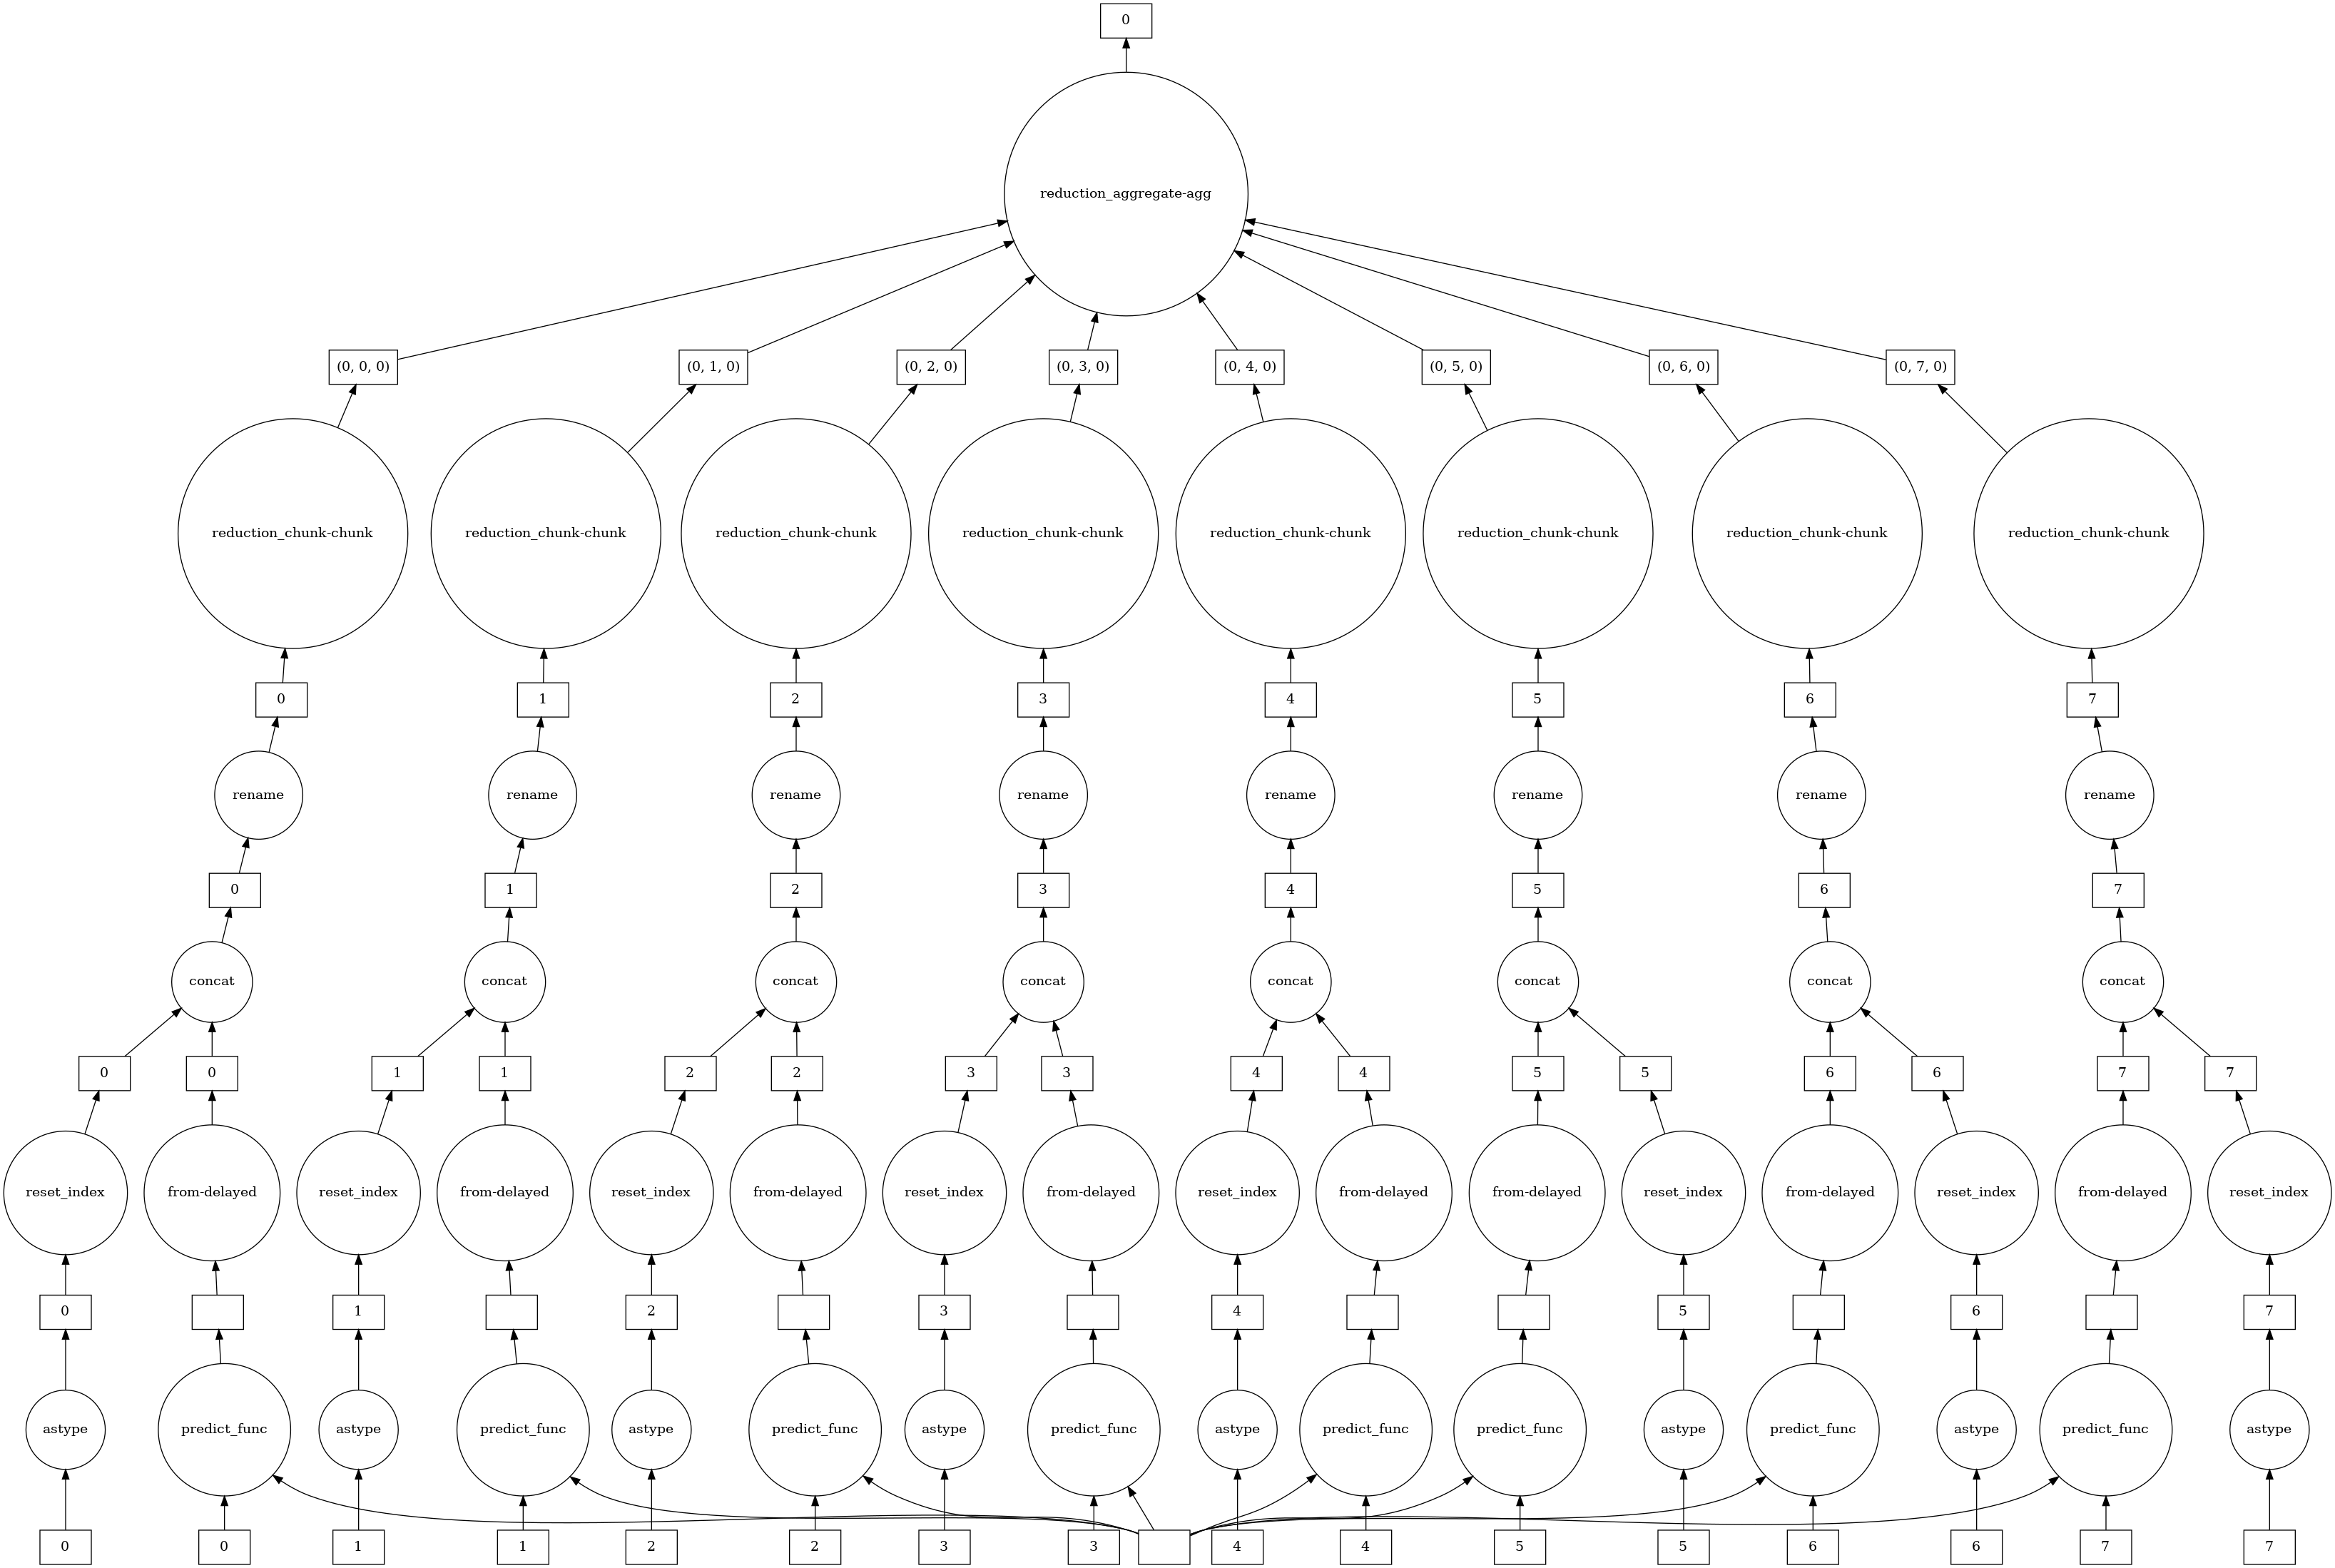

In [86]:
weighted_accuracy_avg.visualize()